In [1]:

import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [9]:

source = '/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod'
session = '20171009_CE059'
# session = '20170927_CE059'
acquisition = 'FOV1_zoom3x'
functional_dir = 'functional'

curr_file_idx = 6 #5
curr_slice_idx = 0 #1 #0 #1 #20

# source = '/nas/volume1/2photon/projects'
# experiment = 'scenes'
# session = '20171003_JW016'
# acquisition = 'FOV1'
# functional_dir = 'functional'
# 
# curr_file_idx = 2
# curr_slice_idx = 20
curr_roi_method = 'blobs_DoG2'
plot_traces = True #False

acquisition_dir = os.path.join(source, experiment, session, acquisition)
figdir = os.path.join(acquisition_dir, 'example_figures')

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)
    
# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)


In [10]:

# Get masks for each slice: 
roi_methods_dir = os.path.join(acquisition_dir, 'ROIs')
roiparams = loadmat(os.path.join(roi_methods_dir, curr_roi_method, 'roiparams.mat'))
maskpaths = roiparams['roiparams']['maskpaths']
if not isinstance(maskpaths, list):
    maskpaths = [maskpaths]

masks = dict(("Slice%02d" % int(slice_idx+1), dict()) for slice_idx in range(len(maskpaths)))
for slice_idx,maskpath in enumerate(sorted(maskpaths, key=natural_keys)):
    slice_name = "Slice%02d" % int(slice_idx+1)
    print "Loading masks: %s..." % slice_name 
    currmasks = loadmat(maskpath); currmasks = currmasks['masks']
    masks[slice_name]['nrois'] =  currmasks.shape[2]
    masks[slice_name]['masks'] = currmasks

slice_names = sorted(masks.keys(), key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = slice_names[curr_slice_idx]


Loading masks: Slice01...
SLICE NAMES: ['Slice01']


In [13]:

# Get FILE list:
average_source = 'Averaged_Slices_Corrected_mcparams01'
signal_channel = 1
average_slice_dir = os.path.join(acquisition_dir, functional_dir, 'DATA', average_source, "Channel{:02d}".format(signal_channel))
file_names = [f for f in os.listdir(average_slice_dir) if '_vis' not in f]
print "File names:", file_names
nfiles = len(file_names)


File names: ['File001', 'File002', 'File003', 'File004', 'File005', 'File006', 'File007', 'File008', 'File009', 'File010']


In [14]:
# Get AVERAGE slices for current file:
curr_file_name = file_names[curr_file_idx]
#curr_file_name = file_names[ref['refidx']]
curr_slice_dir = os.path.join(average_slice_dir, curr_file_name)
slice_fns = sorted([f for f in os.listdir(curr_slice_dir) if f.endswith('.tif')], key=natural_keys)

# Get average slice image for current-file, current-slice:
curr_slice_fn = slice_fns[curr_slice_idx]
avg_tiff_path = os.path.join(curr_slice_dir, curr_slice_fn)
with tf.TiffFile(avg_tiff_path) as tif:
    avgimg = tif.asarray()


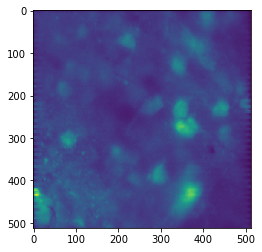

In [15]:
plt.imshow(avgimg)
plt.show()

In [18]:
# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', curr_roi_method, 'mcparams01', 'Parsed')


In [19]:

# Load stim trace structs:
print "Loading parsed traces..."
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fns = sorted([f for f in stimtrace_fns if 'stimtraces' in f and f.endswith('.pkl')], key=natural_keys)
stimtrace_fn = stimtrace_fns[curr_slice_idx]
with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
    stimtraces = pkl.load(f)
    
# stimtraces[stim]['traces'] = np.asarray(curr_traces_allrois)
# stimtraces[stim]['frames_stim_on'] = stim_on_frames 
# stimtraces[stim]['ntrials'] = stim_ntrials[stim]
# stimtraces[stim]['nrois'] = nrois


Loading parsed traces...


In [20]:
currfile='File006'
stim_on_sec = 2.
iti = 1. #4.
nframes = int(simeta[currfile]['SI']['hFastZ']['numVolumes'])
framerate = float(simeta[currfile]['SI']['hRoiManager']['scanFrameRate'])
volumerate = float(simeta[currfile]['SI']['hRoiManager']['scanVolumeRate'])
frames_tsecs = np.arange(0, nframes)*(1/volumerate)

nframes_on = stim_on_sec * volumerate
#nframes_off = vols_per_trial - nframes_on
frames_iti = round(iti * volumerate) 
print nframes_on
print frames_iti

89.4054
45.0


In [21]:
stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)
nrois = stimtraces[stimlist[0]]['nrois']

In [22]:
print nrois

38


In [23]:
# ---------------------------------------------------------------------------
# PLOTTING:
# ----------------------------------------------------------------------------

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(1, max_value, interval)]

    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

color_by_roi = True

spacing = 25
cmaptype = 'rainbow'
colormap = plt.get_cmap(cmaptype)

if color_by_roi:
    colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
else:
    colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

colorvals255 = [c[0:-1]*255 for c in colorvals]
#colorvals = np.true_divide(colorvals255, 255.)
#print len(colorvals255)
roi_interval = 10
plot_rois = np.arange(0, nrois, roi_interval) #int(nrois/2)


In [24]:
print stimtraces[stim]['traces'].shape
for i in range(len(stimtraces[stim]['traces'])):
    print stimtraces[stim]['traces'][i].shape

NameError: name 'stim' is not defined

plotting ROI: 0
[ 0.5  0.   1.   1. ]
1 2 0.0
1 3 0.0
2 2 0.0
2 3 0.0


/home/juliana/anaconda/envs/2pdev/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in divide


3 2 0.0
3 3 0.0
4 2 0.0
4 3 0.0
5 2 0.0
5 3 0.0
6 2 0.0
6 3 0.0
7 2 0.0
7 3 0.0
8 2 0.0
8 3 0.0
9 2 0.0
9 3 0.0
10 2 0.0
10 3 0.0
11 2 0.0
11 3 0.0
12 2 0.0
12 3 0.0
plotting ROI: 10
[ 0.55098039  0.99679532  0.67823512  1.        ]


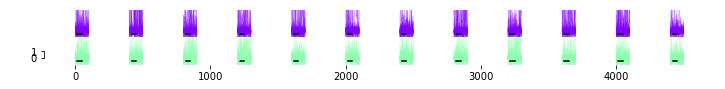

In [55]:
color_by_roi = True
spacing = 400
mw = True

if plot_traces:
    fig = plt.figure(figsize=(nstimuli,int(len(plot_rois)/2)))
    gs = gridspec.GridSpec(len(plot_rois), 1) #, height_ratios=[1,1,1,1]) 
    #gs = gridspec.GridSpec(len([1]), 1)
    gs.update(wspace=0.01, hspace=0.01)
    for ridx,roi in enumerate(plot_rois): #np.arange(0, nrois, 2): # range(plot_rois): # nrois
        #rowindex = roi + roi*nstimuli
        print "plotting ROI:", roi
        plt.subplot(gs[ridx])
        #plt.axis('off')
        #ax = plt.gca()
        print colorvals[roi] 
        currcolor = colorvals[roi]
        for stimnum,stim in enumerate(stimlist):
            #dfs = traces[curr_roi][stim] #[:, roi, :]
            #raw = stimtraces[stim]['traces'][:, :, roi]
            ntrialstmp = len(stimtraces[stim]['traces'])
            nframestmp = min([stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))])
            raw = np.empty((ntrialstmp, nframestmp))
            for trialnum in range(ntrialstmp):
                raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T
                #print raw.shape
            #avg = np.mean(raw, axis=0)
            xvals = np.arange(0, raw.shape[1]) + stimnum*spacing
            #xvals = np.tile(np.arange(0, raw.shape[1]), (raw.shape[0], 1))
            ntrials = raw.shape[0]
            nframes_in_trial = raw.shape[1]
            #print "ntrials: %i, nframes in trial: %i" % (ntrials, nframes_in_trial)
            
            curr_dfs = np.empty((ntrials, nframes_in_trial))
            for trial in range(ntrials):
                if mw is True:
                    #frame_on = int(frames_iti)+1 #stimtraces[stim]['frames_stim_on'][trial][0]
                    frame_on = stimtraces[stim]['frames'][trial].index(stimtraces[stim]['frames_stim_on'][trial][0])
                else:
                    frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
                baseline = np.mean(raw[trial, 0:frame_on])
                if roi==0 and baseline==0:
                    print stim, trial, baseline
                df = (raw[trial,:] - baseline) / baseline
                curr_dfs[trial,:] = df
                if color_by_roi:
                    plt.plot(xvals, df, color=currcolor, alpha=.7, linewidth=0.2)
                else:
                    plt.plot(xvals, df, color=colorvals[stimnum], alpha=1, linewidth=0.2)

            #frames_iti = round(iti * volumerate) 
            if mw is True:
                #start_fr = int(frames_iti)+1
                on_fr_idx = stimtraces[stim]['frames'][trial].index(stimtraces[stim]['frames_stim_on'][trial][0])
                nframes_on = (stimtraces[stim]['frames_stim_on'][trial][1] - stimtraces[stim]['frames_stim_on'][trial][0] + 1)
                off_fr_idx = on_fr_idx + nframes_on - 1
                stim_frames = xvals[0] + [on_fr_idx, off_fr_idx]
            else:
                stim_frames = xvals[0] + stimtraces[stim]['frames_stim_on'][trial] #frames_stim_on[stim][trial]

            plt.plot(stim_frames, np.ones((2,))*-0.5, color='k')

            # Plot average:
            avg = np.mean(curr_dfs, axis=0) 
            if color_by_roi:
                plt.plot(xvals, avg, color=currcolor, alpha=1, linewidth=1.2)
            else:
                plt.plot(xvals, avg, color=colorvals[stimnum], alpha=1, linewidth=1.2)

        if ridx<len(plot_rois)-1:
            #sns.despine(bottom=True)
            plt.axis('off')
            plt.ylabel(str(roi))
        else:
            #plt.axes.get_yaxis().set_visible(True)
            #ax.axes.get_xaxis().set_ticks([])
            plt.yticks([0, 1])

        plt.ylim([-1, 3])

    #fig.tight_layout()
    sns.despine(bottom=True, offset=.5, trim=True)

    figname = 'all_rois_traces_by_stim.png'
    #plt.savefig(os.path.join(figdir, figname), bbox_inches='tight', pad=0)

plt.show()


In [60]:
stim = '1'
trial = '2'
roi = 0
ntrialstmp = len(stimtraces[stim]['traces'])
nframestmp = min([stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))])
raw = np.ones((ntrialstmp, nframestmp))*np.nan
for trialnum in range(ntrialstmp):
    raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T

In [64]:
stimtraces[stim]['traces'][2][:, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [66]:
trace_dir = os.path.join(acquisition_dir, 'Traces', curr_roi_method)
trace_fns = os.listdir(trace_dir)
trace_fns = sorted([t for t in trace_fns if 'traces_Slice' in t], key=natural_keys)
trace_fns

['traces_Slice01_Channel01.mat',
 'traces_Slice02_Channel01.mat',
 'traces_Slice03_Channel01.mat']

In [67]:
from mat2py import loadmat

In [83]:
tracestruct = loadmat(os.path.join(trace_dir, trace_fns[2]))
tracestruct

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Oct 16 20:13:57 2017',
 '__version__': '1.0',
 'file': array([<scipy.io.matlab.mio5_params.mat_struct object at 0x7f95faab9f10>,
        <scipy.io.matlab.mio5_params.mat_struct object at 0x7f95faa74d10>], dtype=object)}

In [84]:
for fi in range(len(tracestruct['file'])):
    print fi, sum(tracestruct['file'][fi].tracematDC[:, 0])

0 438009770.039
1 0.0
2 -2205416.64052
3 836754974.209
4 597510024.928
5 201806584.196
6 363354065.542
7 619296779.111
8 314469409.614
9 368695165.961
10 432517742.085
11 732635018.575
12 1037328552.38
13 484874649.497
14 -298850091.183


In [14]:
len(stimtraces['stim']['frames'][trial][0:int(frame_on)])/volumerate

1.0066506049970136

In [15]:
(stimtraces[stim]['frames_stim_on'][trial][1] - stimtraces[stim]['frames_stim_on'][trial][0] + 1)/volumerate

1.999999999999992

In [16]:
(stimtraces[stim]['frames_stim_on'][trial][1] - stimtraces[stim]['frames_stim_on'][trial][0] + 1) #/volumerate

89.40539999999964

In [17]:
on_fr_idx = stimtraces[stim]['frames'][trial].index(stimtraces[stim]['frames_stim_on'][trial][0])
off_fr_idx = stimtraces[stim]['frames_stim_on'][trial][1] - stimtraces[stim]['frames_stim_on'][trial][0] + 1
stim_frames = xvals[0] + [on_fr_idx, off_fr_idx]
print stim_frames

[ 4445.      4489.4054]


In [18]:
print frame_on
print on_fr_idx

45
45


In [19]:
print stim_frames[0]
print stim_frames[1]
print (stim_frames[1]-stim_frames[0] + 1)/volumerate

4445.0
4489.4054
1.01571940845


In [20]:
# [start_fr start_fr+nframes_on]
start_fr = int(frames_iti)
print start_fr
print start_fr + nframes_on
print xvals[0] + [start_fr, start_fr+nframes_on]

45
134.4054
[ 4445.      4534.4054]


### Draw ROIs on slice image:

In [25]:
colorvals = np.zeros((nrois, 3))
colorvals[:,1] = 1

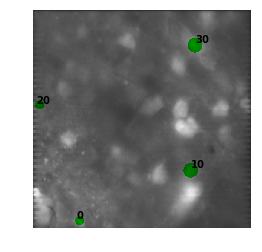

In [63]:
# PLOT ROIs:
img = np.copy(avgimg)

plt.figure()
# plt.imshow(img)
#img = exposure.rescale_intensity(avgimg, in_range=(avgimg.min(), avgimg.max()))
img = np.copy(avgimg)
factor = 1
imgnorm = np.true_divide((img - img.min()), factor*(img.max()-img.min()))
#imgnorm += (1./factor) #0.25

imgnorm[imgnorm<0.8] += 0.15


# img_uint = img_as_ubyte(imgnorm)
# img_float = img_as_float(img_uint)

#label_masks = np.zeros((curr_masks.shape[0], curr_masks.shape[1]))
#print label_masks.shape
# 
#imgnorm = np.random.rand(nr, nc)
alpha = 0.9 #0.8 #1 #0.8 #0.5 #0.99 #0.8
nr,nc = imgnorm.shape
color_mask = np.zeros((nr, nc, 3))
#color_mask = np.dstack((imgnorm, imgnorm, imgnorm)) 
for roi in plot_rois:
    color_mask[currmasks[:,:,roi]==1] = colorvals[roi][0:3]

# Construct RGB version of grey-level image
img_color = np.dstack((imgnorm, imgnorm, imgnorm))

# Convert the input image and color mask to Hue Saturation Value (HSV)
# colorspace
img_hsv = color.rgb2hsv(img_color)
color_mask_hsv = color.rgb2hsv(color_mask)

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] #* alpha
#img_hsv[..., 2] = 0.5

img_masked = color.hsv2rgb(img_hsv)

plt.figure()
plt.imshow(img_masked, cmap=cmaptype)

for roi in plot_rois:
    [ys, xs] = np.where(currmasks[:,:,roi]==1)
    plt.text(xs[int(round(len(xs)/4))], ys[int(round(len(ys)/4))], str(roi), weight='bold')
    
plt.axis('off')
plt.show()
# figname = 'all_rois_average_slice.png'
# plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
# # 


In [43]:
import math
math.mode(ys)

AttributeError: 'module' object has no attribute 'mode'

In [24]:
[ys, xs] = np.where(currmasks[:,:,roi]==1)

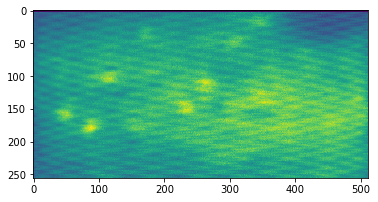

In [93]:
# Get AVERAGE slices for current file:
curr_file_name = file_names[3]
#curr_file_name = file_names[ref['refidx']]
curr_slice_dir = os.path.join(average_slice_dir, curr_file_name)
slice_fns = sorted([f for f in os.listdir(curr_slice_dir) if f.endswith('.tif')], key=natural_keys)

# Get average slice image for current-file, current-slice:
curr_slice_fn = slice_fns[0]
avg_tiff_path = os.path.join(curr_slice_dir, curr_slice_fn)
with tf.TiffFile(avg_tiff_path) as tif:
    avgimg = tif.asarray()
plt.imshow(avgimg)
plt.show()